In [1]:
base_path = '/Users/serhii/Desktop/saliency-prediction'
sources_path = base_path + '/dataset_taskvis/source'
target_task_free_path = base_path + '/dataset_taskvis/gt_tf/heatmaps_accum/10000/'
target_task_specific_path = base_path + '/dataset_taskvis/gt/heatmaps_accum/10000/'

task_free_parameters = base_path + '/model_20230205_123729_99'
task_specific_parameters = base_path + '/model_20230205_191220_290'

LABELS = {'A': 0, 'B': 1, 'C': 2}

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from fcn import FCN
from task_free_branch import TaskFreeBranch
from task_specific_branch import TaskSpecificBranch


/Users/serhii/opt/anaconda3/envs/mlp/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/serhii/opt/anaconda3/envs/mlp/lib/python3.7/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <3224DED3-FCE0-3B10-9D68-9EC019B2AFEC> /Users/serhii/opt/anaconda3/envs/mlp/lib/python3.7/site-packages/torchvision/image.so
  Expected in:     <8B475637-3448-369D-8597-CB8AE9B8A985> /Users/serhii/opt/anaconda3/envs/mlp/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
class Dataset(Dataset):
    def __init__(self, source_dir, target_tf, target_dir, transformations):
        self.source_images = np.repeat([os.path.join(source_dir, x) for x in sorted(os.listdir(source_dir))], 3)
        self.target_images = [os.path.join(target_dir, x) for x in sorted(os.listdir(target_dir))]
        self.transformations = transformations
        
    
    def __len__(self):
        return len(self.target_images)
    
    
    def __getitem__(self, idx):
        source_path = self.source_images[idx]
        source_img = Image.open(source_path).convert('RGB')
        target_tf = Image.open(target_task_free_path + source_path.split('/')[-1].split('/')[-1])
        target_ts = Image.open(self.target_images[idx])

        task_label = target_ts.filename.split('_')[-1].split('.')[0]
        task_label = nn.functional.one_hot(torch.tensor(LABELS[task_label]), 3).to(torch.float32)
        
        source_img = self.transformations(source_img)
        target_tf = self.transformations(target_tf)
        target_ts = self.transformations(target_ts)
        return (source_img, target_tf, target_ts, task_label)


def load_dataset():
    transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    dataset = Dataset(sources_path, target_task_free_path, target_task_specific_path, transformations)
    return dataset

In [4]:
import torch

def pearson_correlation(x, y):
    mean_x = x.mean()
    mean_y = y.mean()
    xm = x - mean_x
    ym = y - mean_y
    r_num = (xm * ym).sum()
    r_den = torch.sqrt((xm ** 2).sum() * (ym ** 2).sum())
    return r_num / r_den


  0%|                                                                                                                                                                  | 0/90 [00:00<?, ?it/s]

CC: 0.7301673293113708, task label: tensor([[0., 1., 0.]])


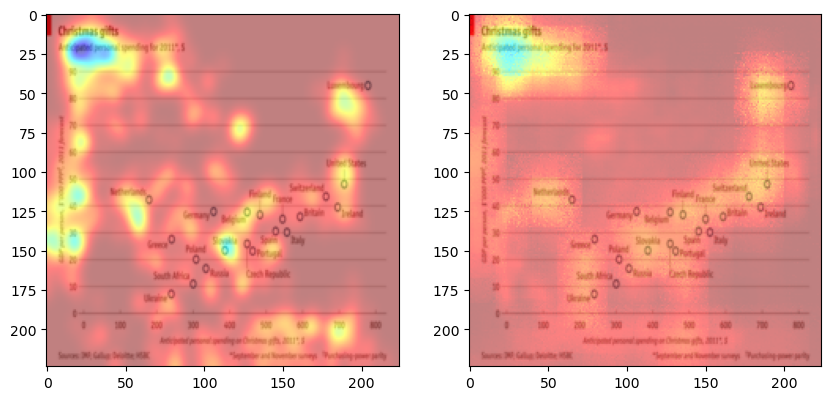

  1%|█▋                                                                                                                                                        | 1/90 [00:02<04:19,  2.92s/it]

CC: 0.8739424347877502, task label: tensor([[0., 0., 1.]])


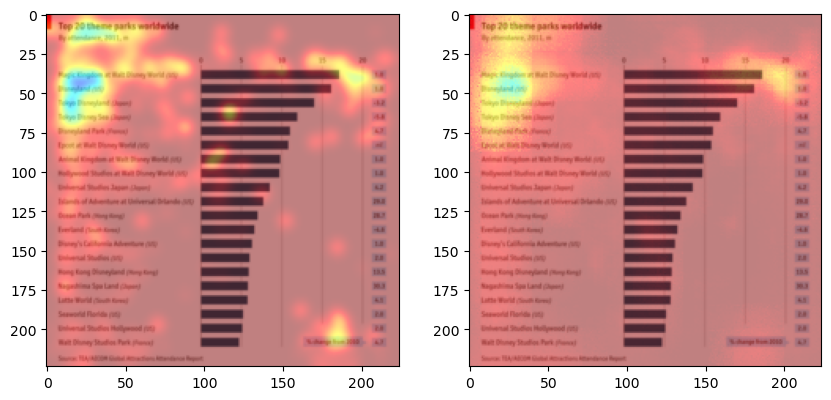

  2%|███▍                                                                                                                                                      | 2/90 [00:05<04:04,  2.78s/it]

CC: 0.8681840896606445, task label: tensor([[0., 0., 1.]])


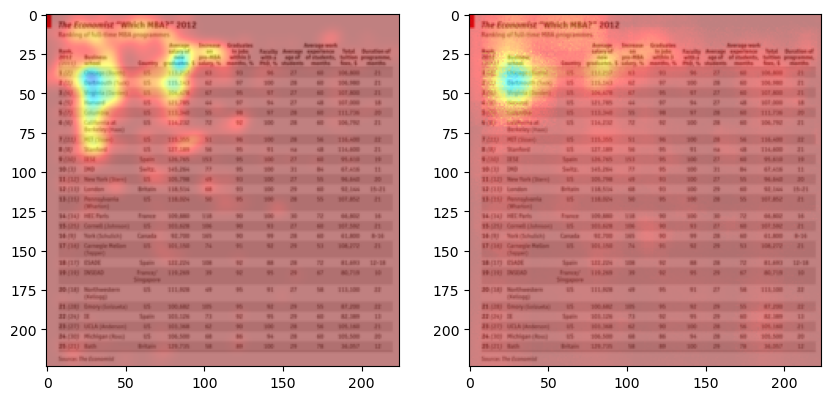

  3%|█████▏                                                                                                                                                    | 3/90 [00:08<04:17,  2.96s/it]

CC: 0.8712750673294067, task label: tensor([[0., 0., 1.]])


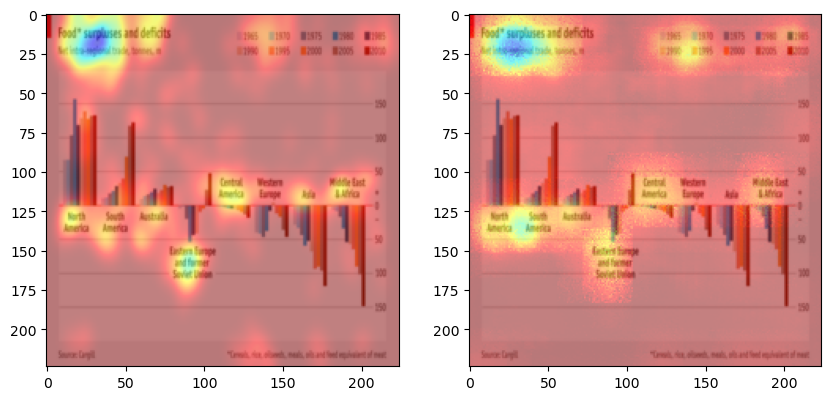

  4%|██████▊                                                                                                                                                   | 4/90 [00:11<03:56,  2.74s/it]

CC: 0.8868061304092407, task label: tensor([[1., 0., 0.]])


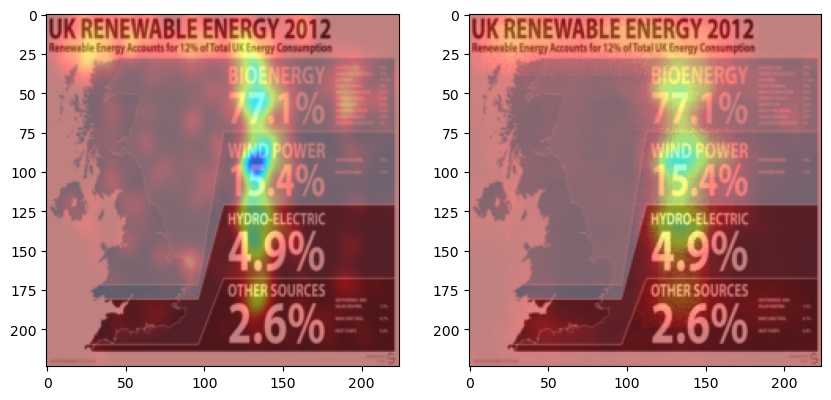

  6%|████████▌                                                                                                                                                 | 5/90 [00:13<03:34,  2.53s/it]

CC: 0.8727845549583435, task label: tensor([[0., 0., 1.]])


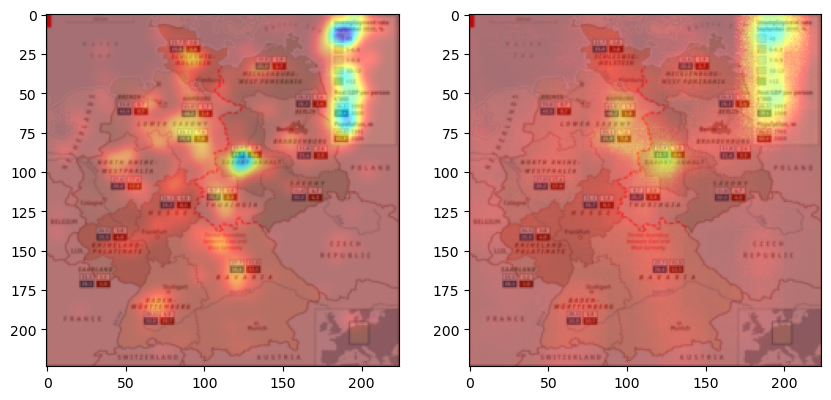

  7%|██████████▎                                                                                                                                               | 6/90 [00:15<03:23,  2.43s/it]

CC: 0.8624897599220276, task label: tensor([[1., 0., 0.]])


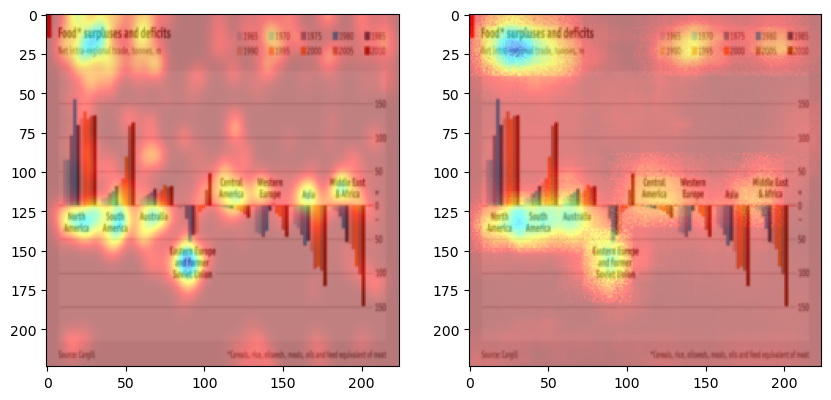

  8%|███████████▉                                                                                                                                              | 7/90 [00:17<03:18,  2.39s/it]

CC: 0.9349897503852844, task label: tensor([[0., 0., 1.]])


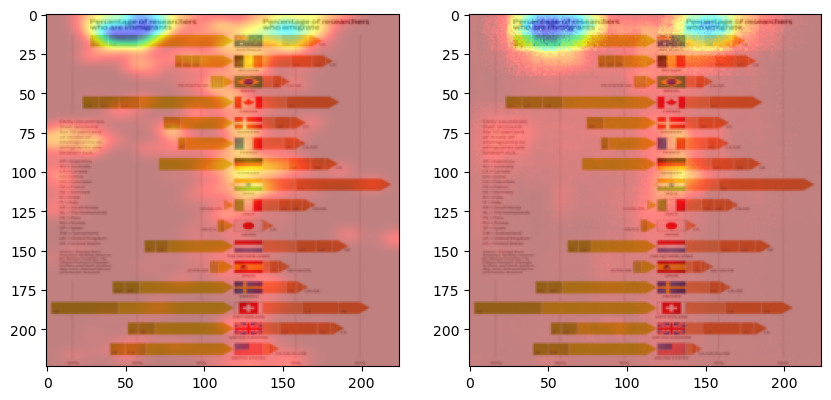

  9%|█████████████▋                                                                                                                                            | 8/90 [00:20<03:16,  2.40s/it]

CC: 0.8803871273994446, task label: tensor([[0., 1., 0.]])


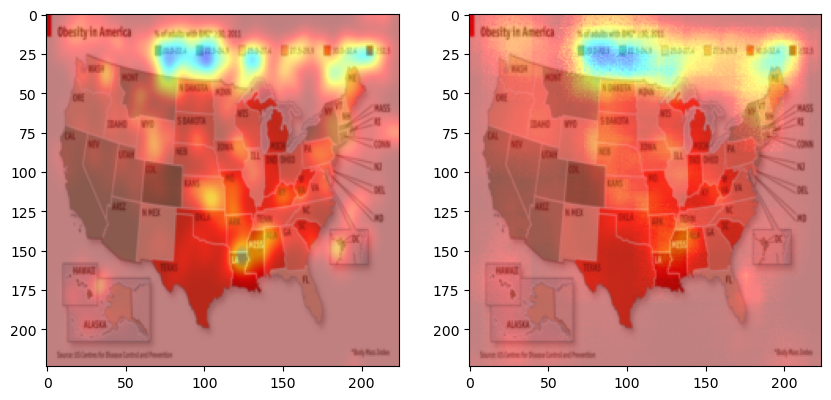

 10%|███████████████▍                                                                                                                                          | 9/90 [00:22<03:12,  2.37s/it]

CC: 0.8654953241348267, task label: tensor([[1., 0., 0.]])


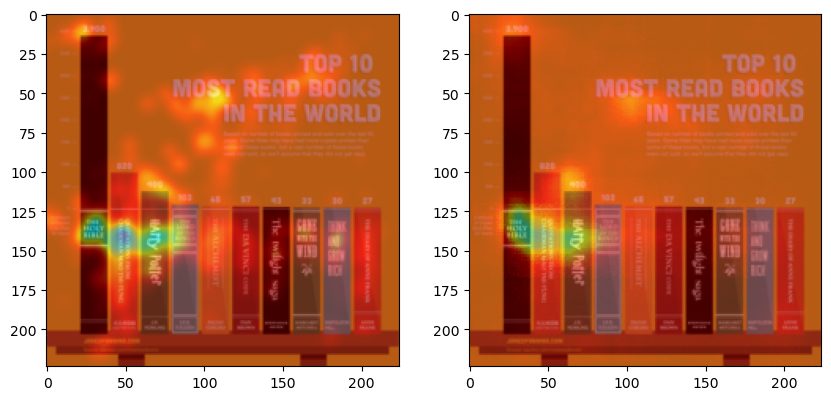

 11%|█████████████████                                                                                                                                        | 10/90 [00:24<03:07,  2.34s/it]

In [ ]:
data_loader = DataLoader(load_dataset(), batch_size=1, shuffle=True)

task_free_branch = FCN(1)
task_specific_branch = TaskSpecificBranch()
task_free_branch.load_state_dict(torch.load(task_free_parameters, map_location=torch.device('cpu')))
task_specific_branch.load_state_dict(torch.load(task_specific_parameters, map_location=torch.device('cpu')))
task_free_branch.eval()
task_specific_branch.eval()


for source_img, target_tf, target_ts, task_label in tqdm(data_loader):
    pred_tf = task_free_branch(source_img)
    pred_ts = task_specific_branch(source_img, task_label)
    pred_combined = (pred_tf + pred_ts) / 2
    target_combined = (target_tf + target_ts) / 2
    print(f'CC: {pearson_correlation(pred_combined, target_combined)}, task label: {task_label}')
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    
    alpha = .5
    heatmap_ts = cv2.applyColorMap((pred_combined[0].permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_gt_ts = cv2.applyColorMap((target_combined[0].permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8), cv2.COLORMAP_JET)
    image = (source_img[0].permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8)
    
    overlap_predicted_ts = cv2.addWeighted(heatmap_ts, alpha, image, 1 - alpha, 0)
    overlap_gt_ts = cv2.addWeighted(heatmap_gt_ts, alpha, image, 1 - alpha, 0)
    
    axs[0].imshow(overlap_gt_ts, cmap='gray')
    axs[1].imshow(overlap_predicted_ts, cmap='gray')
    plt.show() 
